In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve,auc
import seaborn as sns
from xgboost import XGBClassifier


## 1. Data preprocessing

- The merged dataset containers data leakage features which are features that wouldnt be available in real-world prediction such as `max_delay`, `avg_delay`, `num_bad_months`, `months_total`. The target variable `label`, `id` and `amt_income_total` (to use the log transformed income) are also dropped. The target variable `label` is converted to integer for classification
- Applied one-hot encoding to categorical variables 
- Applied train-test split and SMOTE

In [2]:

df = pd.read_csv("../data/clean_merged.csv")


In [3]:
y = df['label'].astype('int')
leaky_features = ['max_delay', 'avg_delay', 'num_bad_months', 'months_total']
X = df.drop(columns=['label', 'id', 'amt_income_total'] + leaky_features)



In [4]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True) #one-hot encoding
else:
    X_encoded = X

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# apply SMOTE 
smote = SMOTE(random_state=42)
X_balance, y_balance = smote.fit_resample(X_train, y_train)
print(f"Class distribution of y after SMOTE: {Counter(y_balance)}")
print(f"Class distribution of y_test without SMOTE: {Counter(y_test)}")

Class distribution of y after SMOTE: Counter({0: 28672, 1: 28672})
Class distribution of y_test without SMOTE: Counter({0: 7169, 1: 123})


## 2. Random Forest Modelling

### 2.1 Random Forest Model (Initialisation)

In [6]:

# initialise Random Forest 
rf_model = RandomForestClassifier(
    n_estimators=100,        # no. of trees
    max_depth=10,           
    min_samples_split=20,   
    min_samples_leaf=10,
    max_features='sqrt',     # random feature selection, diff trees see different subset of features 
    bootstrap=True,          # bagging, ensemble learning
    random_state=42,
    n_jobs=-1               # for parallel processing
)

rf_model.fit(X_balance, y_balance)

#  predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# performance metrics 
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc = auc(recall, precision)


print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(cm)

print(f"\nRates:")
total_0 = cm[0,0] + cm[0,1]  
total_1 = cm[1,0] + cm[1,1] 
print(f"True Negatives (Correct Class 0): {cm[0,0]}")
print(f"False Positives (Wrong Class 1): {cm[0,1]}")
print(f"False Negatives (Wrong Class 0): {cm[1,0]}")
print(f"True Positives (Correct Class 1): {cm[1,1]}")

print(f"\nSpecificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")



Accuracy: 0.8996
Precision: 0.0379
Recall: 0.2033
F1-Score: 0.0639
ROC AUC: 0.6044
PR AUC: 0.0430

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7169
           1       0.04      0.20      0.06       123

    accuracy                           0.90      7292
   macro avg       0.51      0.56      0.51      7292
weighted avg       0.97      0.90      0.93      7292

Confusion Matrix:
[[6535  634]
 [  98   25]]

Rates:
True Negatives (Correct Class 0): 6535
False Positives (Wrong Class 1): 634
False Negatives (Wrong Class 0): 98
True Positives (Correct Class 1): 25

Specificity (True Negative Rate): 0.9116
False Positive Rate: 0.0884
Sensitivity (Recall/True Positive Rate): 0.2033
False Negative Rate: 0.7967


In [7]:
# Plot ROC curve 
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

NameError: name 'roc_auc' is not defined

<Figure size 800x600 with 0 Axes>

Issues with initial random forest method using dataset with training set balanced using smote:

1. AUC of 0.6 is only slightly better than random guesssing, contradicts the 0.90 accuracy rate. The accuracy rate might be misleading because majority class dominates (`label` = 0 for non default). The model might not be discriminating well between the 2 classes. 

2. Precision, and f1 score are nearly 0 for `label` = 1. Since the minority class is extremely small (about 0.02%), SMOTE might produce unrealisitc synthetic minority points, and the model might be overfitting to the SMOTE-generated data by learning the artificial patterns created by SMOTE but not generalizing well to the test set. Some features are dominated by 0s or categorical dummies.

3. Potential changes made to the initial model: 
 - to lower the threshold to 0.3 from 0.5 to capture more defaulters (true positives) (refer to section 2.2)
 - to change to class_weight="balanced" to replace SMOTE (refer to section 2.3)
 - change the model with features that are engineered (refer to section 2.4)

### 2.2 Random Forest Model (adjusted threshold)

In [ ]:


rf_model2 = RandomForestClassifier(
    n_estimators=100,        # no. of trees
    max_depth=10,           
    min_samples_split=20,   
    min_samples_leaf=10,
    max_features='sqrt',     # random feature selection, diff trees see different subset of features 
    bootstrap=True,          # bagging, ensemble learning
    random_state=42,
    n_jobs=-1               # for parallel processing
)

rf_model2.fit(X_balance, y_balance)

y_pred_rf2 = rf_model2.predict(X_test)
y_pred_proba_rf2 = rf_model2.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_adj = (y_pred_proba_rf2 >= threshold).astype(int)


# performance metrics 
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_rf2)
pr_auc = auc(recall, precision)


print(f"Accuracy: {accuracy_score(y_test, y_pred_adj):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_adj):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_adj):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_adj):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf2):.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adj))

# confusion Matrix
cm = confusion_matrix(y_test, y_pred_adj)
print("Confusion Matrix:")
print(cm)

print(f"\nRates:")
total_0 = cm[0,0] + cm[0,1]  
total_1 = cm[1,0] + cm[1,1] 
print(f"True Negatives (Correct Class 0): {cm[0,0]}")
print(f"False Positives (Wrong Class 1): {cm[0,1]}")
print(f"False Negatives (Wrong Class 0): {cm[1,0]}")
print(f"True Positives (Correct Class 1): {cm[1,1]}")

print(f"\nSpecificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")


Accuracy: 0.5499
Precision: 0.0227
Recall: 0.6098
F1-Score: 0.0437
ROC AUC: 0.6044
PR AUC: 0.0430

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.55      0.71      7169
           1       0.02      0.61      0.04       123

    accuracy                           0.55      7292
   macro avg       0.51      0.58      0.37      7292
weighted avg       0.97      0.55      0.69      7292

Confusion Matrix:
[[3935 3234]
 [  48   75]]

Rates:
True Negatives (Correct Class 0): 3935
False Positives (Wrong Class 1): 3234
False Negatives (Wrong Class 0): 48
True Positives (Correct Class 1): 75

Specificity (True Negative Rate): 0.5489
False Positive Rate: 0.4511
Sensitivity (Recall/True Positive Rate): 0.6098
False Negative Rate: 0.3902


Recall for `label` = 1 increase significantly but at the cost of much lower precision, F1-score and accuracy. Most non-defaulters are now wrongly flagged as defaulters. Adjusting threshold does not quite solve the issue since the model cannot tell defaulters apart confidently. Even at threshold 0.3, only a small group of samples truly correspond to real defaulters.

### 2.3 Random Forest Model (use class-weight balancing instead of smote) 


In [ ]:

rf_model_cw = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    min_samples_split=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model_cw.fit(X_train, y_train)


y_pred_cw = rf_model_cw.predict(X_test)
y_pred_proba_cw = rf_model_cw.predict_proba(X_test)[:, 1] 

cv_scores_rf = cross_val_score(rf_model_cw, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_cw)
pr_auc = auc(recall, precision)


print(f"Accuracy: {accuracy_score(y_test, y_pred_cw):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_cw):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_cw):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_cw):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_cw):.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\n Classification Report")
print(classification_report(y_test, y_pred_cw))


print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_cw)
print(cm)

print(f"\nRates:")
print(f"True Negatives (Correct Class 0): {cm[0,0]}")
print(f"False Positives (Wrong Class 1): {cm[0,1]}")
print(f"False Negatives (Wrong Class 0): {cm[1,0]}")
print(f"True Positives (Correct Class 1): {cm[1,1]}")

total_0 = cm[0,0] + cm[0,1]  
total_1 = cm[1,0] + cm[1,1] 

print(f"\nSpecificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")



Cross-Validation AUC: 0.7302 (+/- 0.0294)
Accuracy: 0.9604
Precision: 0.1542
Recall: 0.3008
F1-Score: 0.2039
ROC AUC: 0.6905
PR AUC: 0.1080

 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7169
           1       0.15      0.30      0.20       123

    accuracy                           0.96      7292
   macro avg       0.57      0.64      0.59      7292
weighted avg       0.97      0.96      0.97      7292

Confusion Matrix:
[[6966  203]
 [  86   37]]

Rates:
True Negatives (Correct Class 0): 6966
False Positives (Wrong Class 1): 203
False Negatives (Wrong Class 0): 86
True Positives (Correct Class 1): 37

Specificity (True Negative Rate): 0.9717
False Positive Rate: 0.0283
Sensitivity (Recall/True Positive Rate): 0.3008
False Negative Rate: 0.6992


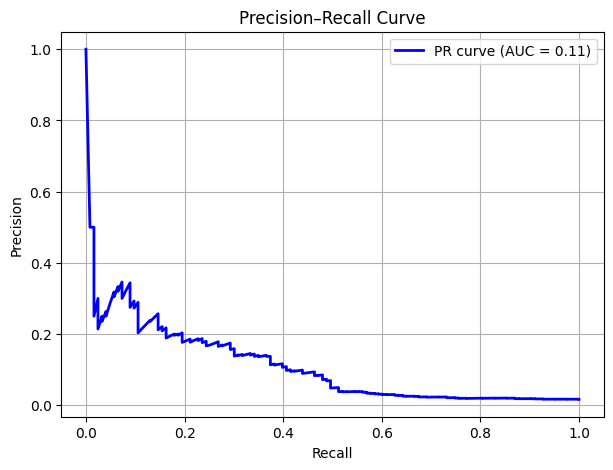

In [ ]:
# precision recall curve
plt.figure(figsize=(7,5))
plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Most of the performance metric values improved quite a bit from the model that uses smote especially recall, false negative rate, pr auc which are most important as having high false negative rate can be quite costly if a defaulter is wrongly predicted as non-defaulter. Even though PR AUC improved slightly, but the model may be doing slightly better than random guessing only because the features might not provide enough information to distinguish between defaulters and non-defaulters. The model still struggles to detect the minority class effectively. Feature engineering will be done under the section 2.4

### 2.4 Random Forest Model  With Feature Engineering

####   2.4.1 Check feature importance

In [ ]:
# get feature importance
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_model_cw.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))


                     feature  importance
11            years_employed    0.163267
9                        age    0.151398
12            amt_income_log    0.144031
8            cnt_fam_members    0.042842
3               cnt_children    0.032215
2            flag_own_realty    0.031911
1               flag_own_car    0.027611
6                 flag_phone    0.027553
16  name_income_type_Working    0.025975
0                code_gender    0.023057


Based on the feature importance for the top 10 features, only the top 3 features seem to have predictive power as all other features have importance of less than 0.01. 

#### 2.4.2 Feature Engineering

In [ ]:

import warnings
warnings.filterwarnings('ignore')

def new_features(X):
   
    X_eng = X.copy()
    
    # use ratio
    if 'years_employed' in X.columns and 'age' in X.columns:
        X_eng['career_ratio'] = X['years_employed'] / (X['age'] + 1)
        X_eng['employment_stability'] = X['years_employed'] / (X['age'] - 18 + 1)  # Years since adult
    
    if 'amt_income_log' in X.columns and 'cnt_fam_members' in X.columns:
        X_eng['income_per_member'] = X['amt_income_log'] / (X['cnt_fam_members'] + 1)
        X_eng['log_income_per_member'] = np.log1p(X_eng['income_per_member'])
    
    # interaction ierms
    if 'age' in X.columns and 'amt_income_log' in X.columns:
        X_eng['age_income_interaction'] = X['age'] * X['amt_income_log']
        X_eng['age_income_ratio'] = X['age'] / (X['amt_income_log'] + 1)
    
    # nonlinear transf
    if 'age' in X.columns:
        X_eng['age_squared'] = X['age'] ** 2
        X_eng['age_cubed'] = X['age'] ** 3
        X_eng['log_age'] = np.log1p(X['age'])
    
    if 'years_employed' in X.columns:
        X_eng['employment_squared'] = X['years_employed'] ** 2
        X_eng['log_employment'] = np.log1p(X['years_employed'] + 1)
    

    return X_eng

# apply the feature engineering defined above
X_engineered = new_features(X_encoded)

# use one-hot encoding for cat variables
categorical_eng_cols = X_engineered.select_dtypes(include=['object', 'category']).columns
if len(categorical_eng_cols) > 0:
    X_engineered = pd.get_dummies(X_engineered, columns=categorical_eng_cols, drop_first=True)

X_train_eng, X_test_eng, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42, stratify=y
)

#  feature selection using correlation with target
correlations = X_train_eng.corrwith(y_train).abs().sort_values(ascending=False)

# select top correlated features
selected_features = correlations[correlations > 0.01].index.tolist()
if len(selected_features) < 20: 
    selected_features = correlations.head(30).index.tolist()

print(f"Selected {len(selected_features)} features for modeling")

X_train_selected = X_train_eng[selected_features]
X_test_selected = X_test_eng[selected_features]



Selected 30 features for modeling


#### 2.4.3 Modelling

In [ ]:

rf_engineered = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_engineered.fit(X_train_selected, y_train)


cv_scores = cross_val_score(rf_engineered, X_train_selected, y_train, 
                           cv=5, scoring='roc_auc', n_jobs=-1)
print(f"Cross-Validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

y_pred_eng = rf_engineered.predict(X_test_selected)
y_pred_proba_eng = rf_engineered.predict_proba(X_test_selected)[:, 1]



Cross-Validation AUC: 0.7390 (+/- 0.0103)


#### 2.4.4 Evaluation of Performance Metrics

In [ ]:

def evaluation(model_name, y_test, y_pred_eng, y_pred_proba_eng, feature_names, model):
    print(f"\n{model_name} Evaluation")


    roc_auc_value = roc_auc_score(y_test, y_pred_proba_eng)
    acc = accuracy_score(y_test, y_pred_eng)
    prec = precision_score(y_test, y_pred_eng)
    rec = recall_score(y_test, y_pred_eng)
    f1 = f1_score(y_test, y_pred_eng)
    pr_precision, pr_recall, _ = precision_recall_curve(y_test, y_pred_proba_eng)
    pr_auc_value = auc(pr_recall, pr_precision)


    print(f"ROC AUC: {roc_auc_value:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"PR AUC:  {pr_auc_value:.4f}") 
    
    # Confusion Matrix
    print(f"\nConfusion Matrix")
    cm = confusion_matrix(y_test, y_pred_eng)
    print(cm)
   
    total_0 = cm[0,0] + cm[0,1]
    total_1 = cm[1,0] + cm[1,1]

    print(f"\nRates:")
    print(f"True Negatives (Correct Class 0): {cm[0,0]}")
    print(f"False Positives (Wrong Class 1): {cm[0,1]}")
    print(f"False Negatives (Wrong Class 0): {cm[1,0]}")
    print(f"True Positives (Correct Class 1): {cm[1,1]}")

    print(f"\nSpecificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
    print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
    print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
    print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")

    # for plotting in part 2.4.5
    return {
        'roc_auc': roc_auc_value,
        'pr_auc': pr_auc_value,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'confusion_matrix': cm
    }
#1.  evaluate engineered model
results_eng = evaluation(
    "Random Forest with Feature Engineering", 
    y_test, y_pred_eng, y_pred_proba_eng, 
    selected_features, rf_engineered
)


# 2.  train "baseline" model (using class weight (rf_model_cw), no feature engineering)

results_cw = evaluation(
    "Random Forest Baseline (No Engineering)", 
    y_test, y_pred_cw, y_pred_proba_cw, 
    X_train.columns, rf_model_cw
)


Random Forest with Feature Engineering Evaluation
ROC AUC: 0.7172
Accuracy: 0.9616
Precision: 0.1897
Recall: 0.3902
F1-Score: 0.2553
PR AUC:  0.1227

Confusion Matrix
[[6964  205]
 [  75   48]]

Rates:
True Negatives (Correct Class 0): 6964
False Positives (Wrong Class 1): 205
False Negatives (Wrong Class 0): 75
True Positives (Correct Class 1): 48

Specificity (True Negative Rate): 0.9714
False Positive Rate: 0.0286
Sensitivity (Recall/True Positive Rate): 0.3902
False Negative Rate: 0.6098

Random Forest Baseline (No Engineering) Evaluation
ROC AUC: 0.6905
Accuracy: 0.9604
Precision: 0.1542
Recall: 0.3008
F1-Score: 0.2039
PR AUC:  0.1080

Confusion Matrix
[[6966  203]
 [  86   37]]

Rates:
True Negatives (Correct Class 0): 6966
False Positives (Wrong Class 1): 203
False Negatives (Wrong Class 0): 86
True Positives (Correct Class 1): 37

Specificity (True Negative Rate): 0.9717
False Positive Rate: 0.0283
Sensitivity (Recall/True Positive Rate): 0.3008
False Negative Rate: 0.6992


For the random forest model with feature engineered features, most of the performance metrics improved quite a bit as compared to the baseline model of random forest using class-weighting. 
1. The model is moderately strong. It performs significantly better than random guessing and slightly better than the baseline
2. After feature engineering, the model identifies more true positives with slightly better confidence, however, more needs to be done to reduce the false negative rate which can be very costly error. 

#### 2.4.5 Visualisation

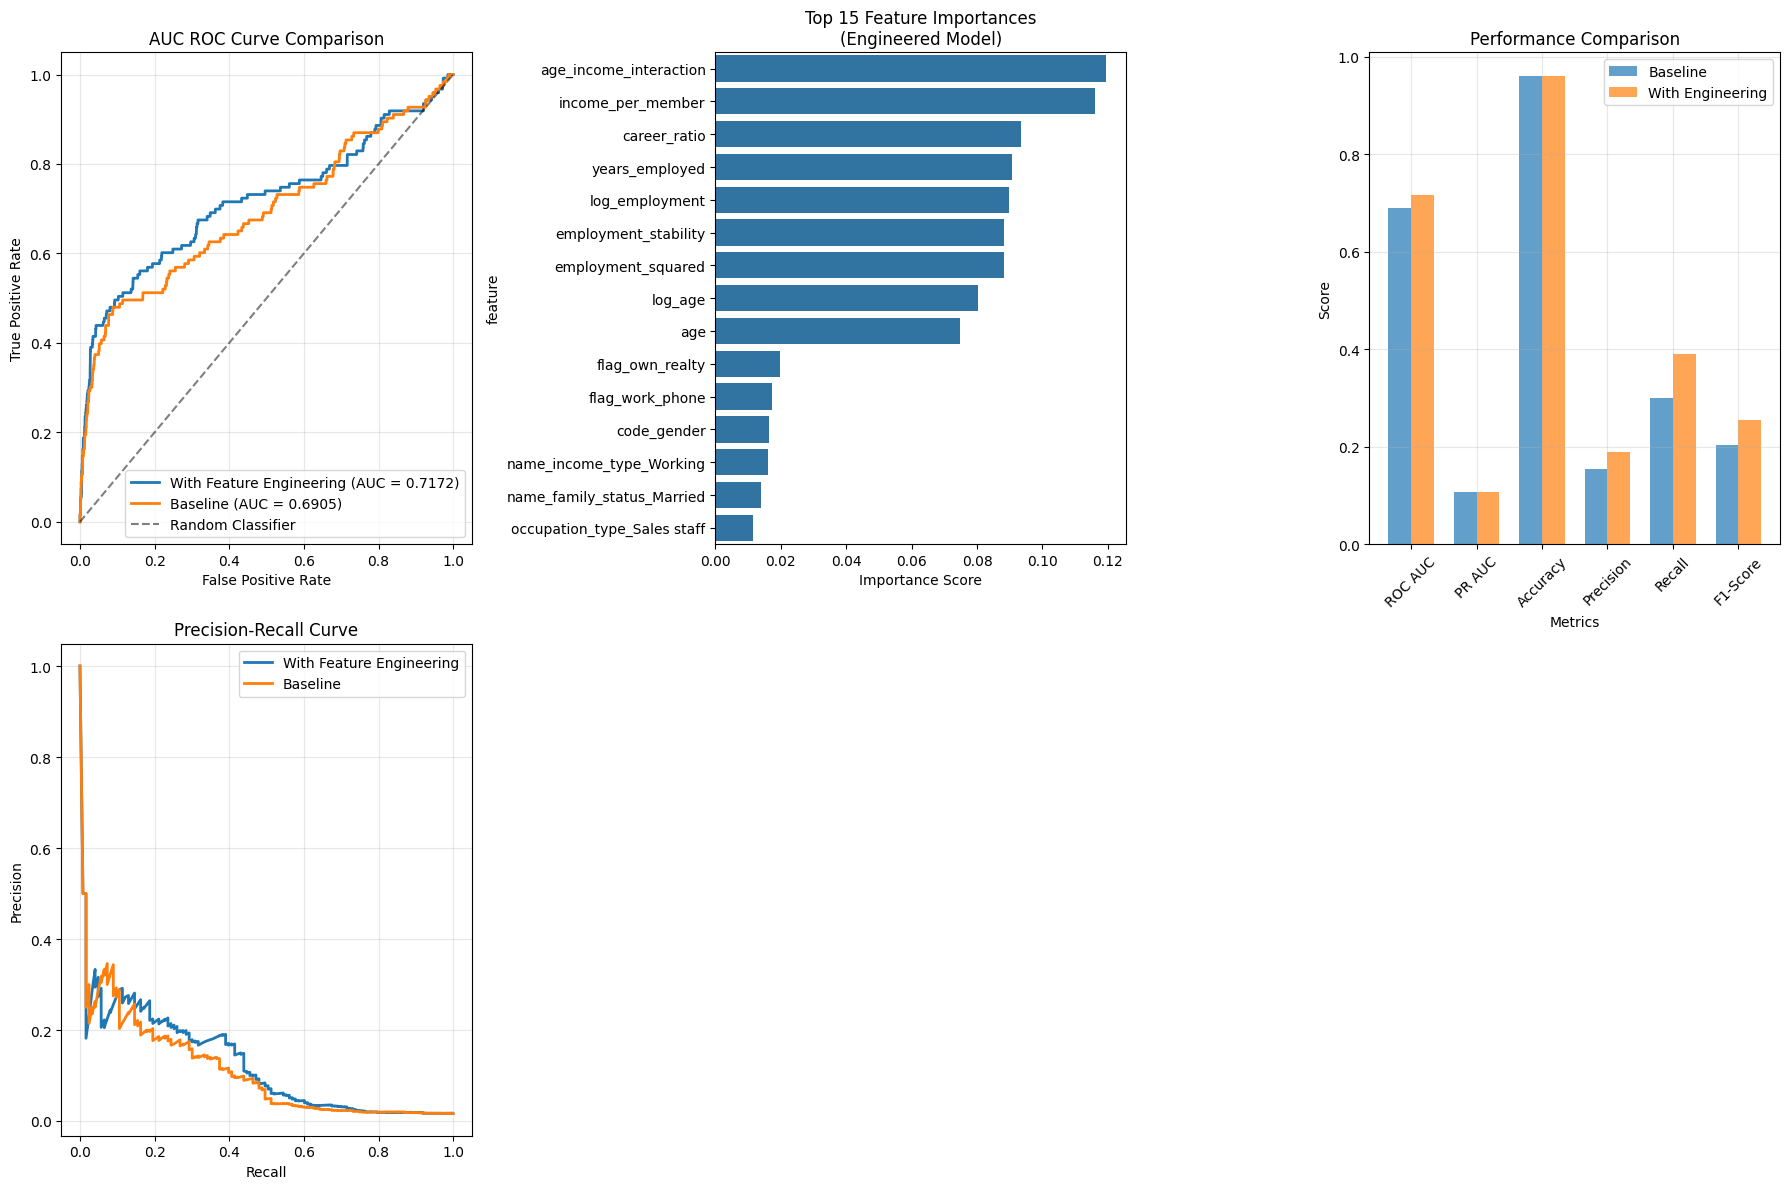

In [ ]:


plt.figure(figsize=(18, 12))

# auc roc curve comparison plot
plt.subplot(2, 3, 1)
fpr_eng, tpr_eng, _ = roc_curve(y_test, y_pred_proba_eng)
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_cw)

plt.plot(fpr_eng, tpr_eng, label=f'With Feature Engineering (AUC = {results_eng["roc_auc"]:.4f})', linewidth=2)
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC = {results_cw["roc_auc"]:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC ROC Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

#  feature importance plot (show new features)
plt.subplot(2, 3, 2)
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_engineered.feature_importances_
}).sort_values('importance', ascending=False).head(15)

sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Top 15 Feature Importances\n(Engineered Model)')
plt.xlabel('Importance Score')

# performance metrics comparison plot
plt.subplot(2, 3, 3)
metrics = ['ROC AUC', 'PR AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
base_values = [results_cw['roc_auc'], results_cw['pr_auc'],results_cw['accuracy'], results_cw['precision'], 
               results_cw['recall'], results_cw['f1']]
eng_values = [results_eng['roc_auc'], results_cw['pr_auc'], results_eng['accuracy'], results_eng['precision'], 
              results_eng['recall'], results_eng['f1']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, base_values, width, label='Baseline', alpha=0.7)
plt.bar(x + width/2, eng_values, width, label='With Engineering', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# precision recall curve plot
plt.subplot(2, 3, 4)
precision_eng, recall_eng, _ = precision_recall_curve(y_test, y_pred_proba_eng)
precision_base, recall_base, _ = precision_recall_curve(y_test, y_pred_proba_cw)

plt.plot(recall_eng, precision_eng, label='With Feature Engineering', linewidth=2)
plt.plot(recall_base, precision_base, label='Baseline', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. XGBOOST Model

Cross-Validation AUC: 0.7575 (+/- 0.0266)

--- RANDOM FOREST WITH CLASS WEIGHT EVALUATION ---
AUC: 0.6905
Accuracy: 0.9604
Precision: 0.1542
Recall: 0.3008
F1-Score: 0.2039

Confusion Matrix:
[[6966  203]
 [  86   37]]
TN: 6966, FP: 203, FN: 86, TP: 37
Specificity: 0.9717
False Positive Rate: 0.0283
Sensitivity (Recall): 0.3008
False Negative Rate: 0.6992

--- XGBOOST EVALUATION ---
AUC: 0.7182
Accuracy: 0.9586
Precision: 0.1903
Recall: 0.4472
F1-Score: 0.2670

Confusion Matrix:
[[6935  234]
 [  68   55]]
TN: 6935, FP: 234, FN: 68, TP: 55
Specificity: 0.9674
False Positive Rate: 0.0326
Sensitivity (Recall): 0.4472
False Negative Rate: 0.5528

MODEL COMPARISON SUMMARY
                             model     auc  accuracy  precision  recall  \
0  Random Forest With Class Weight  0.6905    0.9604     0.1542  0.3008   
1                          XGBoost  0.7182    0.9586     0.1903  0.4472   

       f1  
0  0.2039  
1  0.2670  


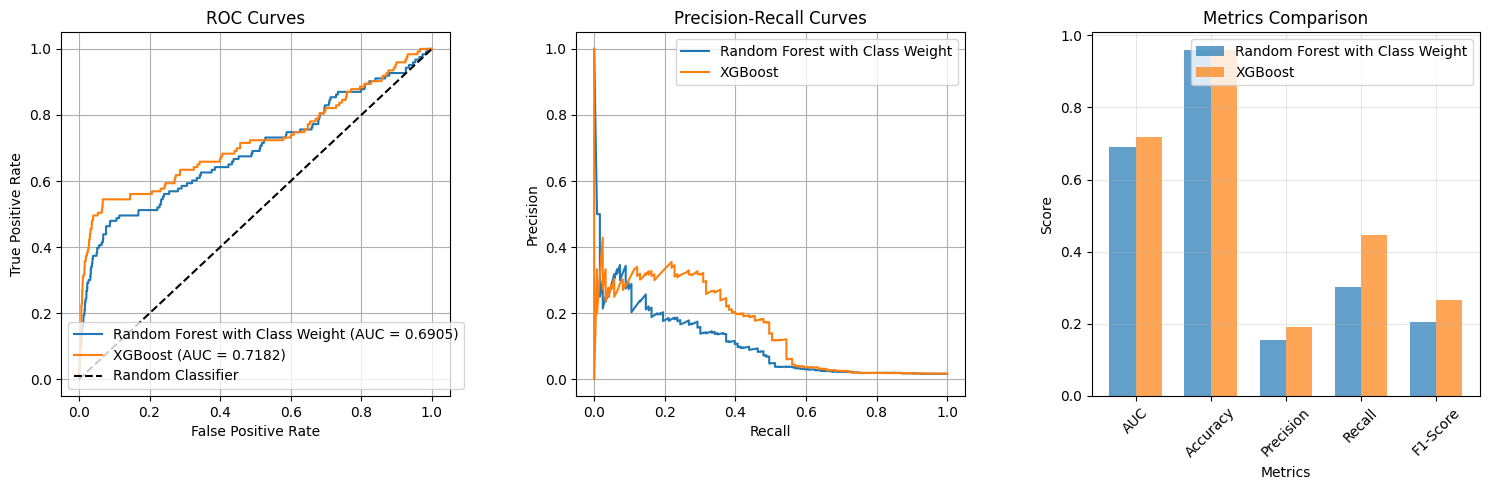

In [ ]:

## XGBoost (with Scale Pos Weight) and with regularisation

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=15,   
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    eval_metric='logloss'
)

# Train
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")

## COMPREHENSIVE EVALUATION FUNCTION
def evaluate_model(model_name, y_true, y_pred, y_pred_proba):
    print(f"\n--- {model_name.upper()} EVALUATION ---")
    
    # Basic metrics
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"TN: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}, TP: {cm[1,1]}")
    
    # Rates
    total_0 = cm[0,0] + cm[0,1]
    total_1 = cm[1,0] + cm[1,1]
    print(f"Specificity: {cm[0,0]/total_0:.4f}")
    print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
    print(f"Sensitivity (Recall): {cm[1,1]/total_1:.4f}")
    print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")
    
    return {
        'model': model_name,
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Evaluate both models
results = []
results.append(evaluate_model("Random Forest With Class Weight", y_test, y_pred_cw, y_pred_proba_cw))
results.append(evaluate_model("XGBoost", y_test, y_pred_xgb, y_pred_proba_xgb))

## COMPARISON SUMMARY

print("\nMODEL COMPARISON SUMMARY")

comparison_df = pd.DataFrame(results)
print(comparison_df[['model', 'auc', 'accuracy', 'precision', 'recall', 'f1']].round(4))



#---------------------------------------


plt.figure(figsize=(15, 5))

# ROC Curve
plt.subplot(1, 3, 1)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_cw)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest with Class Weight (AUC = {roc_auc_score(y_test, y_pred_proba_cw):.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)

# Precision-Recall Curves
plt.subplot(1, 3, 2)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_cw)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)

plt.plot(recall_rf, precision_rf, label='Random Forest with Class Weight')
plt.plot(recall_xgb, precision_xgb, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)

#  Metrics Comparison
plt.subplot(1, 3, 3)
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
rf_metrics = [results[0]['auc'], results[0]['accuracy'], results[0]['precision'], 
              results[0]['recall'], results[0]['f1']]
xgb_metrics = [results[1]['auc'], results[1]['accuracy'], results[1]['precision'], 
               results[1]['recall'], results[1]['f1']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, rf_metrics, width, label='Random Forest with Class Weight', alpha=0.7)
plt.bar(x + width/2, xgb_metrics, width, label='XGBoost', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Metrics Comparison')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Hyperparameter tuning (not complete)